In [77]:
#importing essenstial libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings("ignore")

In [78]:
data = pd.read_excel('Data.xlsx')
data.head()

,Product Code,Date,Actual
0,1147437,M 02.2017,576.0
1,1147437,M 03.2017,1152.0
2,1147437,M 04.2017,432.0
3,1147437,M 05.2017,1296.0
4,1147437,M 06.2017,1153.0


### 3. Making Mape function
MAPE function is used to measure mean absolute percentage error

In [79]:
def MAPE(y_true,y_pred):
    mape = np.mean(np.abs(y_true - y_true)/y_true)
    if mape> 1:
        mape=1
    return mape    

In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9600 entries, 0 to 9599
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Product Code  9600 non-null   int64  
 1   Date          9600 non-null   object 
 2   Actual        8757 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 225.1+ KB


#### Split the date column and making a new Date2 column

In [81]:
#making a column Date_split which contain a list of character 'M' and date
data['Date_split'] = data.Date.str.split(' ')
#making a column Date2 which contain only date from date column
data['Date2'] = data.Date_split.str.get(1)
# droping date and Date_split column
data.drop(['Date','Date_split'],axis=1,inplace=True)
data.head()

,Product Code,Actual,Date2
0,1147437,576.0,02.2017
1,1147437,1152.0,03.2017
2,1147437,432.0,04.2017
3,1147437,1296.0,05.2017
4,1147437,1153.0,06.2017


Changing datatype of date column into datetime object

In [82]:
#changing date2 column into datetime from string
data['Date2'] = pd.to_datetime(data['Date2'],format='%m.%Y')

In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9600 entries, 0 to 9599
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Product Code  9600 non-null   int64         
 1   Actual        8757 non-null   float64       
 2   Date2         9600 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 225.1 KB


In [84]:
#checking for null values
data.apply(lambda x : sum(x.isnull()))

Product Code      0
Actual          843
Date2             0
dtype: int64

### 2. There are some missing sales values, get the count of missing months for a given product and save it in an appropriate memory friendly format

In [85]:
def missingValue(df,col1,col2):
    value = df[df.isnull().any(axis=1)].reset_index()
    df_group = value.groupby(col1)[col2].value_counts()
    return df_group
df_value = missingValue(data,'Product Code','Date2')
df_value.to_json('Missing Value Count.json')


In [86]:
#filling missing value by mean in Actual column
data['Actual'].fillna(data['Actual'].mean(),inplace=True)
data['Actual'].isnull().sum()

0

In [87]:
#checking for last and first date
print(data['Date2'].min())
print(data['Date2'].max())

2017-02-01 00:00:00
2019-09-01 00:00:00


In [88]:
# Setting index to date column
data = data.set_index('Date2')
data.drop('Product Code',axis=1,inplace=True)
data.head()

,Actual
Date2,
2017-02-01,576.0
2017-03-01,1152.0
2017-04-01,432.0
2017-05-01,1296.0
2017-06-01,1153.0


### 1. Find the general distribution of data and get some details about it’s parametric properties.

  Actaul sales is very messy with time and does not have any trends so we resample the data in month wise and checking
  the average sale with month wise
 

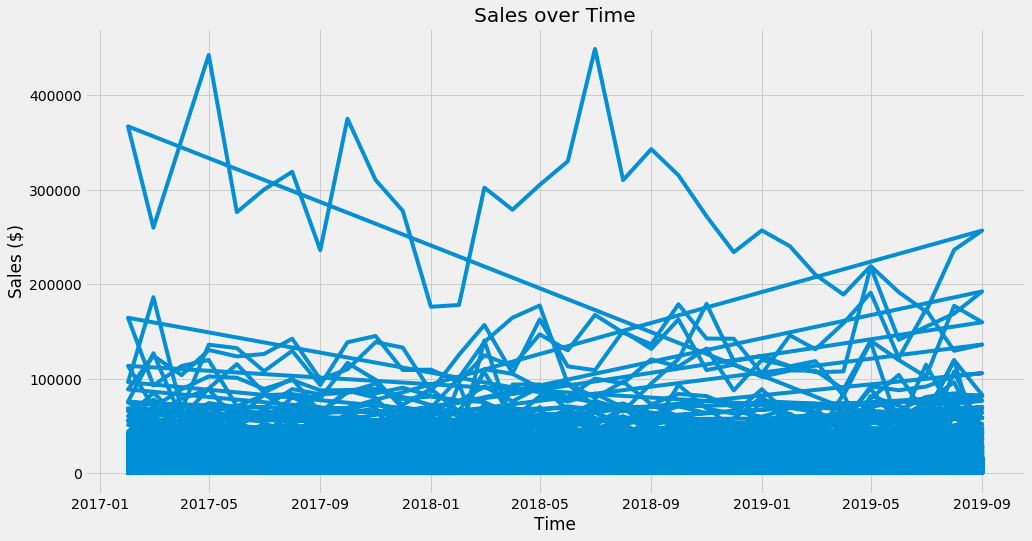

In [89]:
# Ploting actual data with time 
plt.figure(figsize=(15,8))
plt.plot(data['Actual'])
plt.title('Sales over Time')
plt.xlabel('Time')
plt.ylabel('Sales ($)')
plt.show()

### a. Average sales decreased over year

Date2
2017-12-31    15154.594104
2018-12-31    15054.865461
2019-12-31    14884.067700
Freq: A-DEC, Name: Actual, dtype: float64


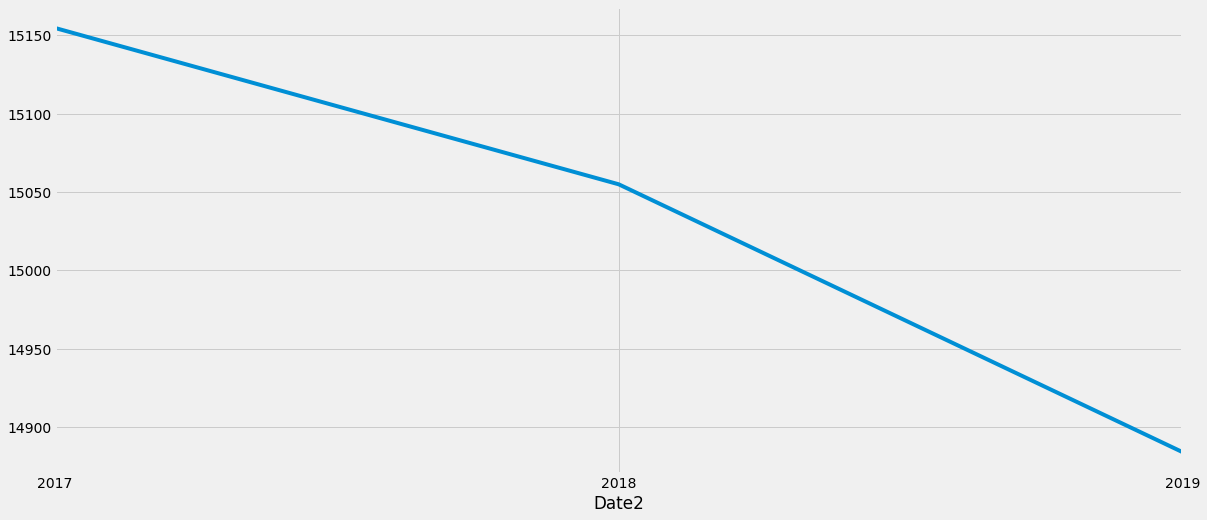

In [90]:
# Grouping the average sale by year and seeing the trend
year_mean = data['Actual'].resample('Y').mean()
print(year_mean)
year_mean.plot()
plt.show()

### Monthely average sale
  Monthly average sales shows seasonality in which seasonality from january to july in each year and it does not show any trends so the sales data is stationary.

In [91]:
#  calcualting average month sales
month_mean = data.resample('MS').mean()
month_mean['2017']

,Actual
Date2,
2017-02-01,15034.419512
2017-03-01,16419.278777
2017-04-01,14274.611743
2017-05-01,16687.945444
2017-06-01,15058.254708
2017-07-01,14200.124341
2017-08-01,16127.358042
2017-09-01,14211.634341
2017-10-01,15421.673605


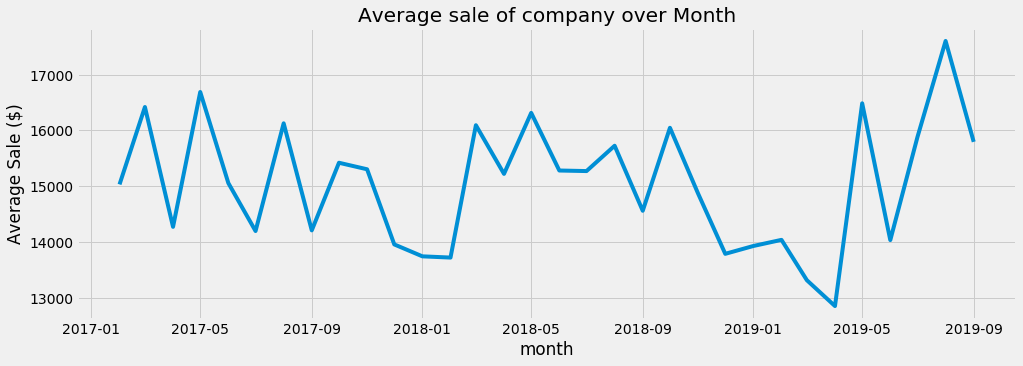

In [92]:
#plotting averge sale by month
plt.figure(figsize=(15,5))
plt.plot(month_mean.Actual)
plt.title('Average sale of company over Month')
plt.ylabel('Average Sale ($)')
plt.xlabel('month')
plt.show()

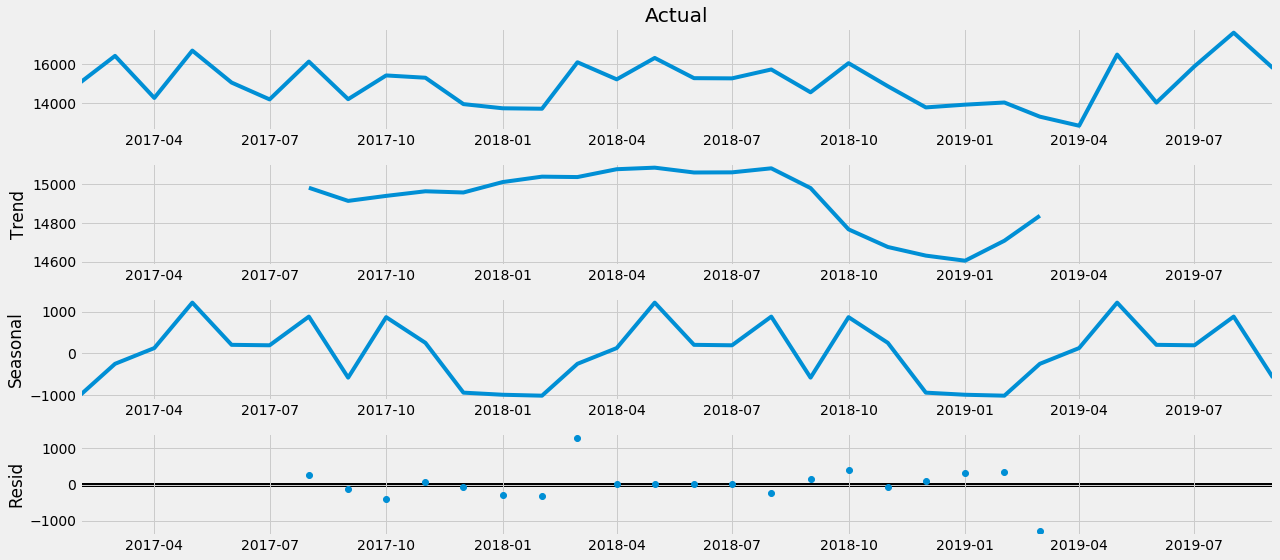

In [93]:
# Ploting Seasonality,trend and residual of average sale of month
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(month_mean.Actual, model='additive')
fig = decomposition.plot()
plt.show()

### Checking Stationarity of the data

Checking the stationarity of data by using Dickey - Fuller test in which p>0 then data is not stationary and if p=0 then data is stationary

Our data is stationary as it shows p=0

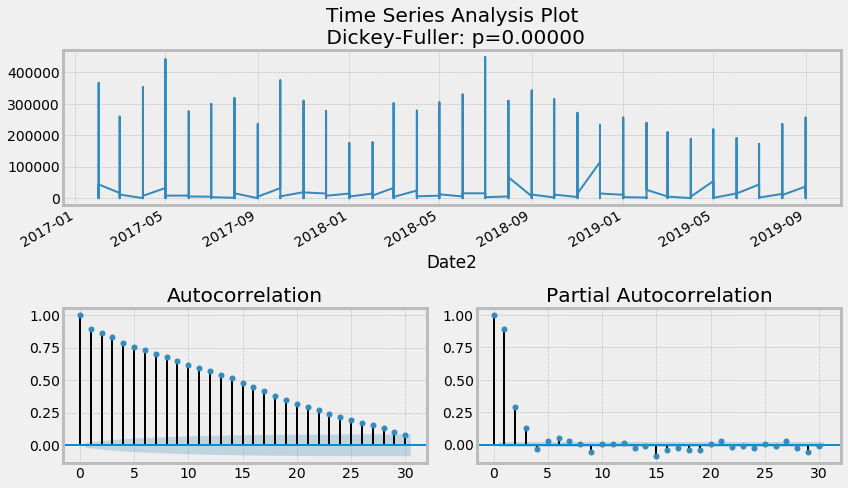

In [94]:
#Checking stationarity of the data
import statsmodels.tsa.api as smt
def checking_Stationary(y, lags=None, figsize= (12,7),syle='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0),colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1),colspan=2)
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plot\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y,lags=lags,ax=acf_ax)
        smt.graphics.plot_pacf(y,lags=lags,ax=pacf_ax)
        plt.tight_layout()
        
checking_Stationary(data.Actual,lags=30)

In [95]:
import statsmodels.api as sm
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [96]:
#Parameter selection
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(month_mean, order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:686.4993215615377
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:404.8117136331437
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:322.5714930094325
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:127.85803660530618
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:341.6276136120914
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:325.962682239475
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:144.42036232636633
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:129.57316189932385
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:645.7970406119407
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:363.08210012736737
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:304.32427917174107
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:104.9341616554962
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:427.38687164233596
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:307.44022392263565
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:143.5133947671784
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:104.03636073254872
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:526.5862985974838
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:314.59591987962887
AR

In [97]:
mod1 = sm.tsa.statespace.SARIMAX(month_mean,order=(1, 1, 1),seasonal_order=(1, 1, 1, 12),enforce_stationarity=False, enforce_invertibility=False)
results1 = mod1.fit()
print(results1.summary())


                                     SARIMAX Results                                      
Dep. Variable:                             Actual   No. Observations:                   32
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -41.278
Date:                            Sun, 12 Jul 2020   AIC                             92.555
Time:                                    20:37:11   BIC                             90.602
Sample:                                02-01-2017   HQIC                            87.314
                                     - 09-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3351      0.704      0.476      0.634      -1.044       1.715
ma.L1         -1.0001      7.476   

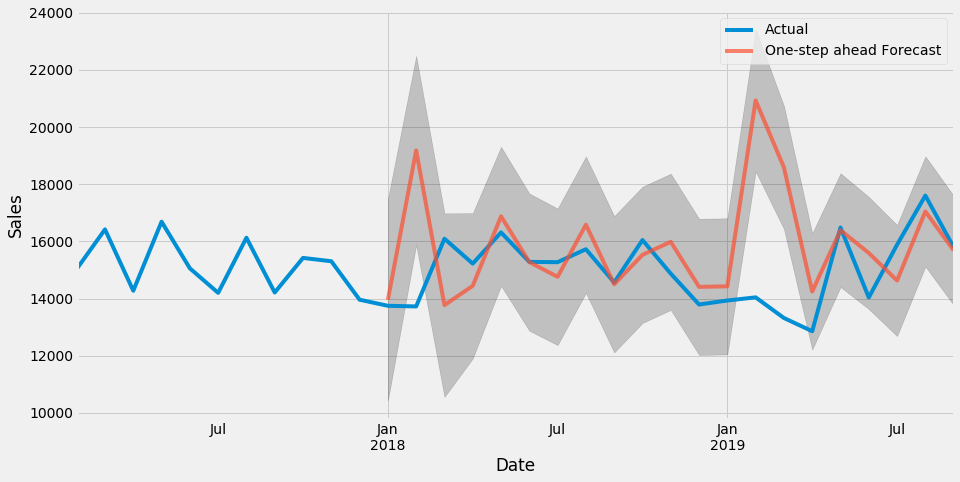

In [98]:
pred = results1.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = month_mean['2017':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

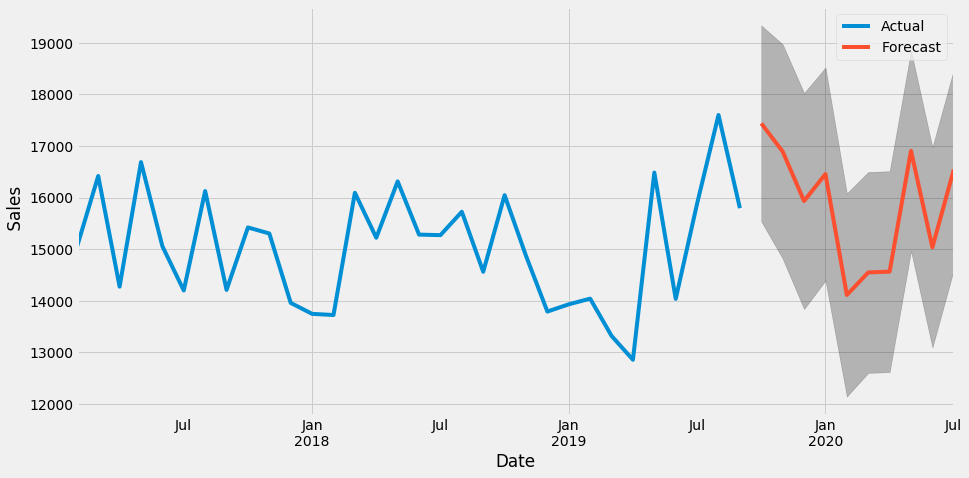

In [99]:
pred_uc = results.get_forecast(steps=10)
pred_ci = pred_uc.conf_int()
ax = month_mean.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel(' Sales')
plt.legend()
plt.show()

In [100]:
print('Predacted value of Average sales for Oct,2019 is {}'.format(pred_uc.predicted_mean['2019-10-01']))

Predacted value of Average sales for Oct,2019 is 17437.94645984449


In [101]:
pred_uc.predicted_mean.to_csv('Prediction.csv')

PermissionError: [Errno 13] Permission denied: 'Prediction.csv'